In [7]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
using LinearAlgebra
using Convex, SCS
using Plots#; pythonplot()
using LaTeXStrings
using Graphs, GraphRecipes
using Random
using NPZ
upscale = 1 #8x upscaling in resolution
fntsm = Plots.font("sans-serif", pointsize=round(20.0*upscale))
fntlg = Plots.font("sans-serif", pointsize=round(23.0*upscale))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
# default(colorbar_tickfontsizes = fntlg, colorbar_titlefontsizes = fntsm)
default(size=(800*upscale,600*upscale)) #Plot canvas size
default(dpi=150) #Only for PyPlot - presently broken

  Activating project at `~/Desktop/PHD/Courses/ME597_project`


In [2]:
L_paper = npzread("paper_graph.npy");

In [95]:
# Function to insert multiple rows at specific indices
function insert_rows_at!(A, rows, indices)
    # Ensure rows and indices are sorted by indices
    sort_perm = sortperm(indices)
    rows = [rows[i] for i in sort_perm]
    indices = sort(indices)
    
    offset = 0
    for i in 1:length(indices)
        insert_index = indices[i] + offset
        A = vcat(A[1:insert_index-1, :], rows[i], A[insert_index:end, :])
        offset += 1
    end
    
    return A
end

function opt_leaders(L, n, l)
    s = Variable(1)
    Y = Variable((n,n))
    p = minimize(s)
    
    p.constraints += Y*L + L*Y ⪯ s*I(n)
    p.constraints += Y*L + L*Y ⪰ -s*I(n)
    
    
    for i ∈ 1:n
        p.constraints += Y[i,i] ≥ 0.0
        p.constraints += Y[i,i] ≤ 1.0
        for j ∈ 1:n
            if i≠j
                p.constraints += Y[i,j] == 0.0
            end
        end
    end
    
    p.constraints += tr(Y) ≥ n-l
    solve!(p, SCS.Optimizer; silent_solver = true)
    argmin(diag(Y.value))
    diag(Y.value)
    
    # Original array
    arr = diag(Y.value)
    
    # Sort the array
    sorted_arr = sort(arr)
    
    # Get the sorted indices
    sorted_indices = sortperm(arr)
    
    # println("Original array: ", arr)
    # println("Sorted array: ", sorted_arr)
    # println("Indices of the sorted array: ", sorted_indices)
    return sorted_indices[1:l]
end


function opt_leaders_2(L, n, l)
    Y = Variable((n,n))
    p = minimize(eigmax(Y*L))
    # p = maximize(eigmin(Y*L))

    
    
    for i ∈ 1:n
        p.constraints += Y[i,i] ≥ 0.0
        p.constraints += Y[i,i] ≤ 1.0
        for j ∈ 1:n
            if i≠j
                p.constraints += Y[i,j] == 0.0
            end
        end
    end
    
    p.constraints += tr(Y) ≥ n-l
    solve!(p, SCS.Optimizer; silent_solver = true)
    argmin(diag(Y.value))
    diag(Y.value)
    
    # Original array
    arr = diag(Y.value)
    
    # Sort the array
    sorted_arr = sort(arr)
    
    # Get the sorted indices
    sorted_indices = sortperm(arr)
    
    # println("Original array: ", arr)
    # println("Sorted array: ", sorted_arr)
    # println("Indices of the sorted array: ", sorted_indices)
    return sorted_indices[1:l]
end



function leader_information(t, Slope::Float64)

    ## Linear Input
    xₗ = zeros(length(t))
    for k=1:(length(t)) 
        if (k <= 0)
            xₗ[k] = 0.0
        elseif (k < length(t)/2)
            xₗ[k] = Slope*k
        else
            xₗ[k] = Slope*length(t)/2
        end
    end
    return xₗ
end


function leader_follower(t, xf₀::Vector{Float64}, xₗ::Vector{Float64}, 
    Af::Matrix{Float64}, Bf, γ::Float64, w::Vector{Float64})

    oneₙ = ones(size(Af)[1])
    # Discretize time with sampling dt
    

    # Preallocate state vector for each time step
    xf = zeros(length(xf₀), length(t))
    # Initial network state
    xf[:,1] .= xₗ[1]

    for k=1:(length(t)-1)      
        # Forward Euler update law

        xf[:,k+1] .= xf[:,k] - γ*Af*xf[:,k] + γ*Bf*xₗ[k] + w

    end
    return t, xf
end

leader_follower (generic function with 2 methods)

In [32]:
function R_eig(S, L)
    if isempty(S)
        return 100000000000.0
    end
    Af = L[1:end .∉ [S], 1:end .∉ [S]]
    R = inv(Af)
    total = minimum(eigvals(Af))
    return total
end


function R(S, L)
    if isempty(S)
        return 100000000000.0
    end
    Af = L[1:end .∉ [S], 1:end .∉ [S]]
    R = inv(Af)
    # total = minimum(eigvals(R))
    total = 0.0
    for u ∈ 1:size(R)[1]#setdiff(1:n, S)
        # @show u
        total += 0.5*R[u,u]
    end
    return total
end


# function argmax_j(S_star, L)
#     followers = setdiff(1:n, S_star)
#     current = R(S_star, L)

#     maxval = -10000000000000.0
#     argmax_idx = -1
#     for j ∈ followers
#         added = union(S_star, j)
#         # valnow = R_eig(added, L)
#         valnow = current - R_eig(added, L)

#         if valnow ≥ maxval
#             maxval = valnow
#             argmax_idx = j
#         end
#     end
#     return argmax_idx, maxval
# end

function argmax_j(S_star, L)
    followers = setdiff(1:n, S_star)
    current = R(S_star, L)

    maxval = -10000000000000.0
    argmax_idx = -1
    for j ∈ followers
        added = union(S_star, j)
        valnow = current - R(added, L)


        if valnow ≥ maxval
            maxval = valnow
            argmax_idx = j
        end
    end
    return argmax_idx, maxval
end

function greedy(k, L)
    
    # S_star = Array{Float64}(undef, 0)
    S_star = Array{Int32}(undef, 0)
    i = 0
    maxval = 0.0
    while i < k
        s_i_star, maxval = argmax_j(S_star, L)
        if maxval <= 0
            return S_star, maxval
        else
            push!(S_star, s_i_star)
            i += 1
        end
        maxval = R(S_star, L)
    end
    return S_star, maxval
end


function greedy_error(α, L)
    
    # S_star = Array{Float64}(undef, 0)
    S_star = Array{Int32}(undef, 0)
    i = 0
    maxval = 0.0
    error = α + 1.0
    while error > α
        s_i_star, maxval = argmax_j(S_star, L)
        if maxval <= 0
            return S_star, maxval
        else
            push!(S_star, s_i_star) 
            i += 1
        end
        maxval = R(S_star, L)
        error = maxval
    end
    return S_star, maxval
end

function rand_alg(k,L)
    S_star = Array{Int32}(undef, 0)
    i = 0
    n = size(L)[1]
    maxval = 0.0
    while i < k
        # s_i_star = rand(1:n)
        s_i_star = rand(setdiff(1:n, S_star))
        push!(S_star, s_i_star)
        i += 1
    end
    maxval = R(S_star, L)
    return S_star, maxval
end

function max_degree_alg(k,L)
    maxval = 0.0
    arr = diag(L)
    sorted_indices = sortperm(arr)
    S_star = reverse(sorted_indices)[1:k]
    maxval = R(S_star, L)
    return S_star, maxval
end

max_degree_alg (generic function with 1 method)

In [48]:
function rand_alg_error(α,L)
    S_star = Array{Int32}(undef, 0)
    i = 0
    n = size(L)[1]
    error = α + 1.0
    maxval = 0.0
    while error > α
        # s_i_star = rand(1:n)
        s_i_star = rand(setdiff(1:n, S_star))
        push!(S_star, s_i_star)
        i += 1
        maxval = R(S_star, L)
        error = maxval
    end
    return S_star, maxval
end

function max_degree_alg_error(α,L)
    S_star = Array{Int32}(undef, 0)
    i = 0
    n = size(L)[1]
    error = α + 1.0
    maxval = 0.0
    arr = diag(L)
    sorted_indices = sortperm(arr)
    all_leaders = reverse(sorted_indices)
    while error > α
        push!(S_star, all_leaders[i+1])
        i += 1
        maxval = R(S_star, L)
        error = maxval
    end
    return S_star, maxval
end

max_degree_alg_error (generic function with 1 method)

In [91]:
using Random
# k = 3
Random.seed!(123)
α_vals = 0.01:0.0005:0.05
r_all_cvx = zeros(length(α_vals))
r_all_greedy = zeros(length(α_vals))
r_all_random = zeros(length(α_vals))
r_all_max_degree = zeros(length(α_vals))

i = 1
# n = 25
n = 100
# G = erdos_renyi(n, 0.5)
L = L_paper
# L = Matrix(laplacian_matrix(G))*1.0

for α ∈ α_vals
    S_star, maxval = greedy_error(α, L)
    r_all_greedy[i] = length(S_star)#maxval

    S_star, maxval = rand_alg_error(α,L)
    r_all_random[i] = length(S_star)

    S_star, maxval_max = max_degree_alg_error(α,L)
    r_all_max_degree[i] = length(S_star)
    i += 1
end

In [94]:
plot(α_vals, r_all_greedy, ylabel="Numbers of leaders needed", xlabel = "Error bound α", markershape = :circle, label="Supermodular", title="100 agent graph")
plot!(α_vals, r_all_random, markershape = :circle, label="Random", color=:green)
p = plot!(α_vals, r_all_max_degree, markershape = :circle, label="Max. degree", color=:purple)
savefig(p, "Error_bound_100_agent_graph.png")
# savefig(p, "Error_bound_Erdos_Renyi.png")

"/home/mohsafwat/Desktop/PHD/Courses/ME597/Project/Error_bound_100_agent_graph.png"

In [52]:
using Random
# k = 3
Random.seed!(123)
k_vals = 1:10
r_all_cvx = zeros(length(k_vals))
r_all_greedy = zeros(length(k_vals))
r_all_random = zeros(length(k_vals))
r_all_max_degree = zeros(length(k_vals))

i = 1
n = 25
# n = 100
G = erdos_renyi(n, 0.5)
# L = L_paper
L = Matrix(laplacian_matrix(G))*1.0

for k ∈ k_vals
    S_star_cvx = opt_leaders(L, n, k)#opt_leaders(L, n, k)
    maxval_cvx = R(S_star_cvx, L)
    r_all_cvx[i] = maxval_cvx
    # @show "cvx"
    # G = path_graph(n)
    # @show n
    S_star, maxval = greedy(k, L)
    r_all_greedy[i] = maxval
    # @show "greedy"

    S_star, maxval = rand_alg(k,L)
    r_all_random[i] = maxval
    # @show "maxval"

    S_star, maxval_max = max_degree_alg(k,L)
    r_all_max_degree[i] = maxval_max
    i += 1
end

In [44]:
plot(k_vals, r_all_greedy, xlabel=L"$k$ leaders", ylabel = L"$R(S)$", markershape = :circle, label="Supermodular", title="Erdos Renyi p=0.5")
plot!(k_vals, r_all_cvx, markershape = :circle, label="Convex Relaxation")
plot!(k_vals, r_all_random, markershape = :circle, label="Random", color=:green)
p = plot!(k_vals, r_all_max_degree, markershape = :circle, label="Max. degree", color=:purple)
# savefig(p, "100_agent_graph.png")
# savefig(p, "Erdos_Renyi.png")

"/home/mohsafwat/Desktop/PHD/Courses/ME597/Project/Erdos_Renyi.png"

In [ ]:
k = 3
Random.seed!(123)
r_all = zeros(length(6:50))
i = 1
for n ∈ 6:50
    # G = erdos_renyi(n, 0.65)
    G = path_graph(n)
    @show n
    L = Matrix(laplacian_matrix(G))*1.0
    S_star, maxval = greedy(k, L)
    r_all[i] = maxval
    i += 1
end

In [ ]:
plot(6:50, r_all, markerstyle=:circle)

In [ ]:
xf₀ = zeros(n-l)
Tf = 5.0
dt = 0.01
γ = 0.5
t = Array(range(0, Tf, step=dt))
# xₗ = leader_information(t, 0.01)
l=3
l_set = opt_leaders(L, n, l)
xₗ = ones(length(t)); xₗ[1] = 0;
Af = L[1:end .∉ [l_set], 1:end .∉ [l_set]]
Bf = Af*ones(n-l);
t, xf = leader_follower(t, xf₀, xₗ, Af, Bf, γ);
# @show norm(xf' .- xₗ, Inf)
plot(t,xf', label = false, color="red", linewidth=3.5*upscale, xlabel="Time (s)"
    , ylabel="Input Signal")
plot!(t, xf[1,:], label = "Convex Relaxation", color="red", linewidth=3.5*upscale)
xₗ = ones(length(t)); xₗ[1] = 0;
S_star, maxval = greedy(l)
Af = L[1:end .∉ [S_star], 1:end .∉ [S_star]]
Bf = Af*ones(n-l);
t, xf = leader_follower(t, xf₀, xₗ, Af, Bf, γ)
@show norm(xf' .- xₗ, Inf)
plot!(t,xf', label = false, color="blue", linewidth=3.5*upscale)
plot!(t, xf[1,:], label = "Supermodular", color="blue", linewidth=3.5*upscale)

In [117]:
using Distributions
d = Normal(0.00, 0.01)
Random.seed!(123)
Tf = 5.0
dt = 0.01
γ = 0.5
t = Array(range(0, Tf, step=dt))
k = 3
n = 20
G = path_graph(n)
xf₀ = zeros(n-k)
w = rand(d,n-k)#0.01*randn(n-k)
xₗ = leader_information(t, 0.03)

L = Matrix(laplacian_matrix(G))*1.0
S_star_greedy, maxval = greedy(k, L)
S_star_greedy = sort(S_star_greedy)

Af = L[1:end .∉ [S_star_greedy], 1:end .∉ [S_star_greedy]]
Bf = Af*ones(n-k);
t, xf_greedy = leader_follower(t, xf₀, xₗ, Af, Bf, γ, w)

S_star_rand, maxval = rand_alg(k,L)
S_star_rand = sort(S_star_rand)

Af = L[1:end .∉ [S_star_rand], 1:end .∉ [S_star_rand]]
Bf = Af*ones(n-k);
t, xf_rand = leader_follower(t, xf₀, xₗ, Af, Bf, γ, w)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99, 5.0], [0.03 0.038082879284649665 … 7.524890066976313 7.524890066976313; 0.03 0.018779274918858266 … 7.5087243084070145 7.5087243084070145; … ; 0.03 0.021099233437301884 … 5.903772965206333 5.90924919740241; 0.03 0.019117814860637128 … 5.870905991636384 5.876457293281995])

In [1]:
x_all_greedy = [xf_greedy[1:S_star_greedy[1]-1,:]; 
xₗ'; 
xf_greedy[S_star_greedy[1]:S_star_greedy[2]-2,:]; 
xₗ';
xf_greedy[S_star_greedy[2]-1:S_star_greedy[3]-3,:]; 
xₗ';
xf_greedy[S_star_greedy[3]-2:end,:]]

x_all_rand = [xf_rand[1:S_star_rand[1]-1,:]; 
xₗ'; 
xf_rand[S_star_rand[1]:S_star_rand[2]-2,:]; 
xₗ';
xf_rand[S_star_rand[2]-1:S_star_rand[3]-3,:]; 
xₗ';
xf_rand[S_star_rand[3]-2:end,:]];

UndefVarError: UndefVarError: `xf_greedy` not defined

In [119]:
x_all_greedy = xf_greedy
x_all_rand = xf_rand

for i ∈ S_star_greedy
    x_all_greedy = insert_rows_at!(x_all_greedy, [xₗ'], [i])
end

for i ∈ S_star_rand
    x_all_rand = insert_rows_at!(x_all_rand, [xₗ'], [i])
end

┌ Info: Saved animation to /home/mohsafwat/Desktop/PHD/Courses/ME597/Project/agents_opt_new.gif
└ @ Plots /home/mohsafwat/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/mohsafwat/Desktop/PHD/Courses/ME597/Project/agents_opt_new.gif")
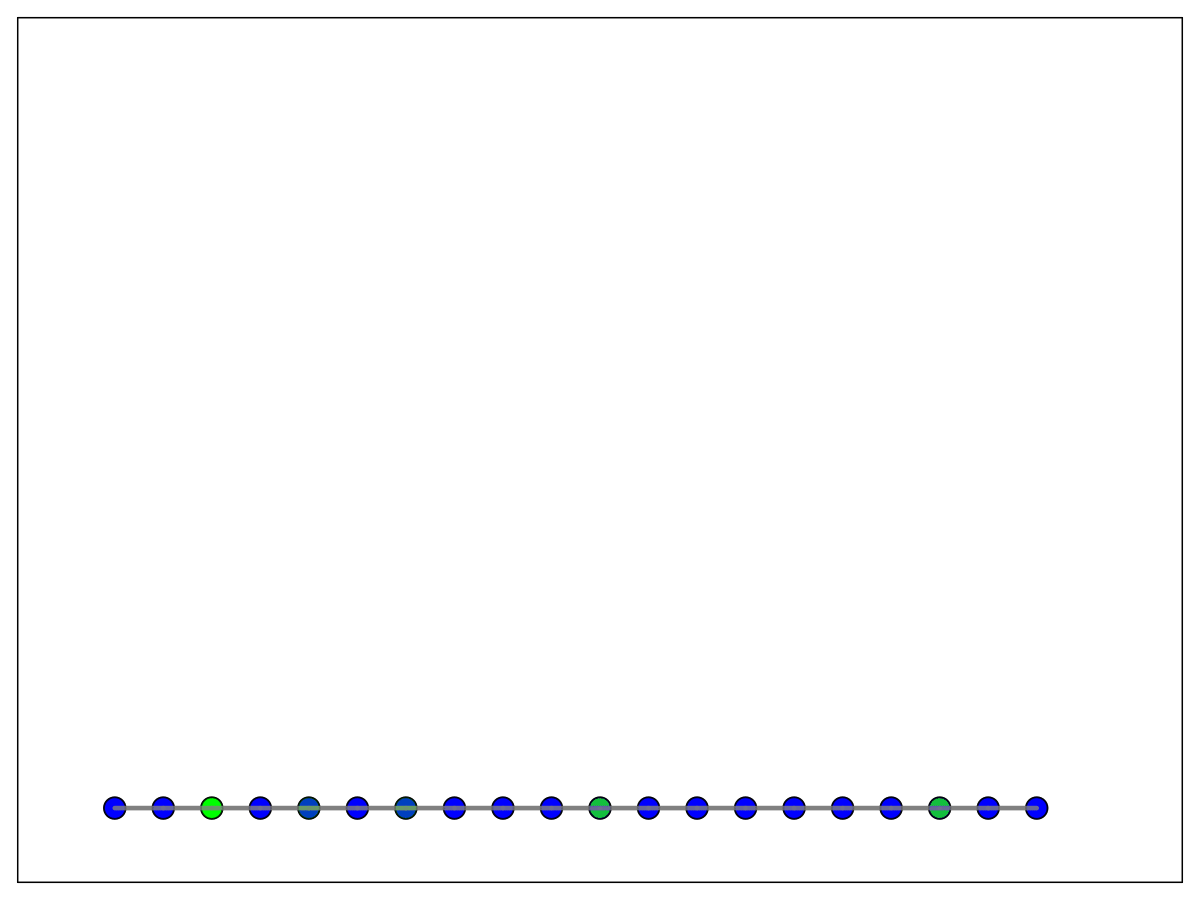

In [120]:
anim = @animate for k in 1:length(t)
    if 1 ∈ S_star_greedy
        col = :lime
    else
        col = :blue
    end

    scatter([0.0], [x_all_greedy[1,k]], m = (:circle, 8), color=col,
    xlims = (-1, 11), 
    ylims = (-1, 11),
    ticks = false, framestyle = :box, 
    legend = false)

    dx = 0.5
    for i ∈ 2:n
        if i ∈ S_star_greedy
            col = :lime
        else
            col = :blue
        end
        scatter!([dx*(i-1)], [x_all_greedy[i,k]], m = (:circle, 8), color=col)
        plot!([dx*(i-1), dx*(i-2)], [x_all_greedy[i,k], x_all_greedy[i-1,k]], linewidth=3*upscale, color=:grey)
    end


    if 1 ∈ S_star_rand
        col = :lime
    else
        col = :blue
    end

    scatter!([0.0], [x_all_rand[1,k]], m = (:circle, 8), color=col, alpha = 0.25)

    dx = 0.5
    for i ∈ 2:n
        if i ∈ S_star_rand
            col = :lime
        else
            col = :blue
        end
        scatter!([dx*(i-1)], [x_all_rand[i,k]], m = (:circle, 8), color=col, alpha = 0.25)
        plot!([dx*(i-1), dx*(i-2)], [x_all_rand[i,k], x_all_rand[i-1,k]], linewidth=3*upscale, color=:grey, alpha = 0.25)
    end



end every 1;
gif(anim, "agents_opt_new.gif")